<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/Xgboost_blackcoal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet


import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

# xgboost라이브러리 추가
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from datetime import datetime

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/df_final.csv", encoding = 'utf-8-sig')
df = df.sort_values('date')
df

,date,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,KPPI,ACPI,...,호주지수,캐나다지수,베트남GDP,인도GDP,한국GDP,일본GDP,중국GDP,미국GDP,EUGDP,세계GDP
469,2011-01-02,136.35,173.50,93.33,9436.0,88.03,88.48,56.16,6.8,220.223,...,4745.200195,13443.200195,1.355394e+11,1.823050e+12,1.253223e+12,6.233147e+12,7.551500e+12,1.554258e+13,1.575949e+13,7.367146e+13
468,2011-01-09,136.00,179.50,98.68,9662.0,91.54,91.66,55.31,6.8,220.223,...,4705.000000,13272.299805,1.355394e+11,1.823050e+12,1.253223e+12,6.233147e+12,7.551500e+12,1.554258e+13,1.575949e+13,7.367146e+13
467,2011-01-16,131.90,178.00,97.60,9462.5,89.11,89.13,55.12,6.8,220.223,...,4801.500000,13464.099609,1.355394e+11,1.823050e+12,1.253223e+12,6.233147e+12,7.551500e+12,1.554258e+13,1.575949e+13,7.367146e+13
466,2011-01-23,130.35,179.50,99.42,9548.5,89.34,89.49,53.73,6.8,220.223,...,4755.700195,13258.599609,1.355394e+11,1.823050e+12,1.253223e+12,6.233147e+12,7.551500e+12,1.554258e+13,1.575949e+13,7.367146e+13
465,2011-01-30,127.00,183.50,99.83,10067.0,89.03,89.13,54.84,6.8,220.223,...,4774.899902,13437.599609,1.355394e+11,1.823050e+12,1.253223e+12,6.233147e+12,7.551500e+12,1.554258e+13,1.575949e+13,7.367146e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2019-12-01,66.40,88.56,64.39,5990.0,59.20,59.11,39.05,0.7,256.974,...,6846.000000,17040.199219,2.619212e+11,2.870504e+12,1.651423e+12,5.148782e+12,1.427994e+13,2.143322e+13,1.568936e+13,8.756805e+13
3,2019-12-08,66.30,92.27,65.22,6130.0,60.07,59.78,35.17,0.7,256.974,...,6707.000000,16997.000000,2.619212e+11,2.870504e+12,1.651423e+12,5.148782e+12,1.427994e+13,2.143322e+13,1.568936e+13,8.756805e+13
2,2019-12-15,66.35,91.74,66.14,6175.0,60.44,60.44,37.12,0.7,256.974,...,6739.700195,17003.099609,2.619212e+11,2.870504e+12,1.651423e+12,5.148782e+12,1.427994e+13,2.143322e+13,1.568936e+13,8.756805e+13
1,2019-12-22,66.55,91.55,68.16,6214.0,61.72,61.74,33.13,0.7,256.974,...,6816.299805,17118.400391,2.619212e+11,2.870504e+12,1.651423e+12,5.148782e+12,1.427994e+13,2.143322e+13,1.568936e+13,8.756805e+13


In [29]:
df = df[['date',
         'Coal_price',
          'copper_fut',
          'bdi',
          'US 달러지수',
          '상하이종합지수',
          '브라질지수',
          '코스피지수',
          '유로스톡스50지수']]
      
df

,date,Coal_price,copper_fut,bdi,US 달러지수,상하이종합지수,브라질지수,코스피지수,유로스톡스50지수
469,2011-01-02,136.35,9436.0,1773,79.288002,2808.076904,69305.0,2051.000000,2807.040039
468,2011-01-09,136.00,9662.0,1519,81.320999,2838.801025,70057.0,2086.199951,2808.250000
467,2011-01-16,131.90,9462.5,1439,79.365997,2791.343994,70940.0,2108.169922,2920.399902
466,2011-01-23,130.35,9548.5,1370,78.370003,2715.293945,69133.0,2069.919922,2970.560059
465,2011-01-30,127.00,10067.0,1137,78.279999,2752.750000,66698.0,2107.870117,2954.129883
...,...,...,...,...,...,...,...,...,...
4,2019-12-01,66.40,5990.0,1528,98.202003,2871.979980,108233.0,2087.959961,3703.580078
3,2019-12-08,66.30,6130.0,1558,97.661003,2912.013916,111126.0,2081.850098,3692.340088
2,2019-12-15,66.35,6175.0,1355,97.170998,2967.676025,112565.0,2170.250000,3731.070068
1,2019-12-22,66.55,6214.0,1123,97.274002,3004.937988,115121.0,2204.179932,3776.560059


In [30]:
df['date'] =  pd.to_datetime(df['date'])
df = df.set_index('date')

df['month'] = df.index.month
df['year'] = df.index.year
df['dayofweek'] = df.index.dayofweek

# 학습과 테스트 데이터 분리
split = "2019-12-01"
df_train = df[:split]
df_test = df[split:]

df_train_y = df_train.loc[:,'Coal_price']
df_train_x = df_train.drop('Coal_price', axis=1)
df_test_y = df_test.loc[:,'Coal_price']
df_test_x = df_test.drop('Coal_price', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
df_test_orig = df_test.loc[:, 'Coal_price']

[07:22:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


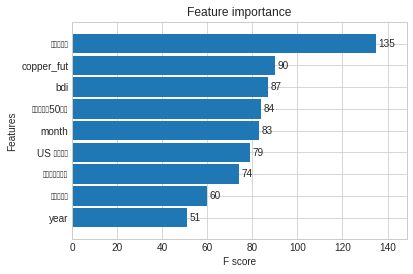

In [31]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

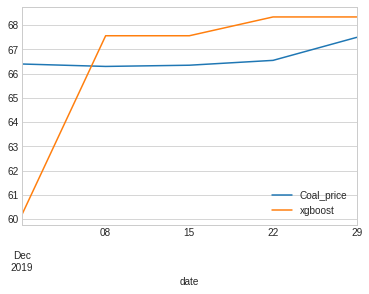

In [32]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_test_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]
result.plot()